# Getting Started With Machine Learning

## Obtain The Data

The data is available in the google drive folder with the presentation and other notebooks. We can use the gdown command to download the data from Google Drive by giving it the file ID: 

In [ ]:
import gdown

file_id = '1Dk2btkiUG2GelH0rWdsria7wuWUkIIIX'
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}",
)

Downloading...
From: https://drive.google.com/uc?id=1dpH6MmwaqFCdc3ErB7btOzoDe4LBOtFc
To: /content/training_set.zip
100% 572M/572M [00:03<00:00, 143MB/s]


If this doesn't work, I have also hosted the data on S3. Uncomment the following line and download the data from S3 if the above command fails

In [ ]:
#!wget https://s3.amazonaws.com/dev.sagardsaxena.com/training_set.zip

--2021-11-13 03:19:23--  https://s3.amazonaws.com/dev.sagardsaxena.com/training_set.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.131.248
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.131.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571567478 (545M) [application/zip]
Saving to: ‘training_set.zip’

training_set.zip    100%[===================>] 545.09M  59.6MB/s    in 10s     

2021-11-13 03:19:34 (52.9 MB/s) - ‘training_set.zip’ saved [571567478/571567478]



If this doesn't work either, you'll have to download and upload the dataset manually using the folder button on the sidebar to the left. I hope we don't need to do this, but these things can happen :/

In [ ]:
!unzip training_set.zip

The code block below makes a test_set with 20% of the data. It is important to have data for testing to make sure that our model is actually learning, and not just memorizing how certain data looks.

In [ ]:
import os
import tqdm
os.system("mkdir -p test_set/class_a")
os.system("mkdir -p test_set/class_b")

dog_imgs = os.listdir("training_set/class_a")
cat_imgs = os.listdir("training_set/class_b")

dog_imgs = dog_imgs[int(len(dog_imgs)*.8):]
cat_imgs = cat_imgs[int(len(cat_imgs)*.8):]

for img in dog_imgs:
  os.system("mv %s %s" % (os.path.join("training_set", "class_a", img), os.path.join("test_set", "class_a", img)))

for img in cat_imgs:
  os.system("mv %s %s" % (os.path.join("training_set", "class_b", img), os.path.join("test_set", "class_b", img)))

In [ ]:
!ls -l "training_set/class_a" | wc -l
!ls -l "test_set/class_a" | wc -l

10001
2501


## Building The Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.preprocessing.image import ImageDataGenerator

We want to create a Sequential Model. Sequential models are great for simple models and easy to work with for developers.

In [ ]:
classifier = Sequential()

The first layer we are going to add is a 2D Convolutional layer. This layer will have 32 filters, a 3x3 sliding window, and will take in the original input image of size 64x64x3. The activation function for this layer will be relu.

In [ ]:
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

The next layer we are going to add is a 2D MaxPooling layer. This layer will have a pool_size of 2x2.

In [ ]:
classifier.add(MaxPooling2D(pool_size = (2, 2)))

Next, we will Flatten our data into a 1D Array.

In [ ]:
classifier.add(Flatten())

Now that our data has been flattened, we will add a Fully Connected layer with 128 nodes. The activation function for this layer will be relu.

In [ ]:
classifier.add(Dense(units = 128, activation = 'relu'))

Lastly, we will add a Fully Connected layer with a single node for our output. The activation function for this layer will be sigmoid. 

In [ ]:
classifier.add(Dense(units = 1, activation = 'sigmoid'))

Now that we've built our model, we are ready to compile it. We can compile the model with an adam optimizer and a binary_crossentropy loss. We can also assign a metric for accuracy that we can get when we train the model.

In [ ]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Loading our Data

The code block below will load our data and add some augmentations. It adds some shear, a horizontal flip, and zoom on the images to give us some more diverse data.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Training The Model

Now we will train the model for 3 epochs on the training_set. We can set the number of steps_per_epoch to $$\frac{20000}{32} \approx 600$$ 

We can also use our test_set as our validation set. This isn't recommended, but for the purposes of this demo it is okay. The number of validation_steps can be set to
$$\frac{5000}{32} \approx 150$$

In [ ]:
classifier.fit_generator(training_set,
                         steps_per_epoch = 600,
                         epochs = 3,
                         validation_data = test_set,
                         validation_steps = 150)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/3
600/600 [==============================] - 102s 169ms/step - loss: 0.5837 - accuracy: 0.6934 - val_loss: 0.5634 - val_accuracy: 0.7088
Epoch 2/3
600/600 [==============================] - 93s 155ms/step - loss: 0.5412 - accuracy: 0.7238 - val_loss: 0.5223 - val_accuracy: 0.7423
Epoch 3/3
600/600 [==============================] - 101s 168ms/step - loss: 0.5162 - accuracy: 0.7433 - val_loss: 0.5309 - val_accuracy: 0.7377


## Let's See How It Did!

In [ ]:
classifier.evaluate(test_set)

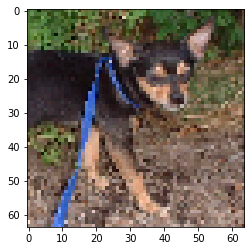

[0.03128327]
dog


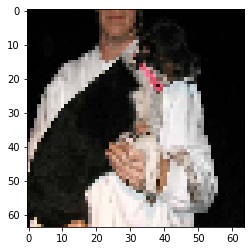

[0.3822097]
dog


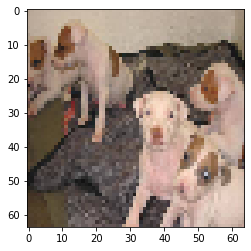

[0.36214775]
dog


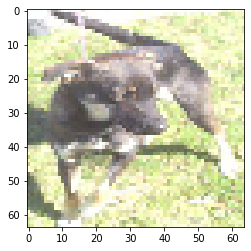

[0.04720727]
dog


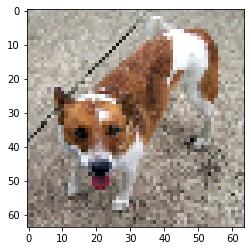

[0.03014478]
dog


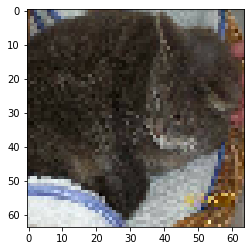

[0.85074]
cat


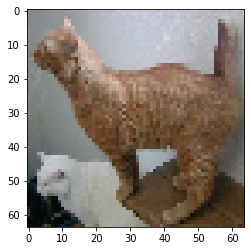

[0.6258427]
cat


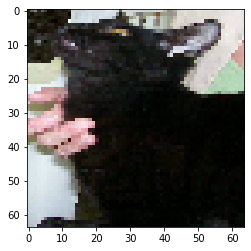

[0.8465422]
cat


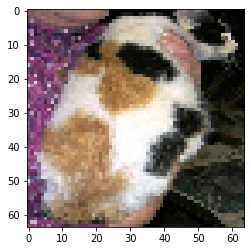

[0.20199612]
dog


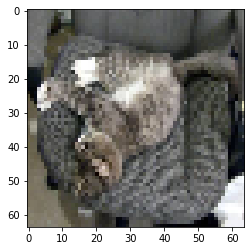

[0.40000656]
dog


In [ ]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dogs = os.listdir("test_set/class_a")[:5]
cats = os.listdir("test_set/class_b")[:5]

def show_prediction(f):
  test_image = image.load_img(f, target_size = (64, 64))
  test_image = image.img_to_array(test_image)/255.0
  plt.imshow(test_image)
  plt.show()
  test_image = np.expand_dims(test_image, axis = 0)
  result = classifier.predict(test_image)
  training_set.class_indices
  print(result[0])
  if result[0][0] < .5:
    prediction = 'dog'
  else:
    prediction = 'cat'
  print(prediction)

for dog in dogs:
  show_prediction(os.path.join("test_set", "class_a", dog))

for cat in cats:
  show_prediction(os.path.join("test_set", "class_b", cat))

# For The Next Workshop

If you all are going to return for the deployment workshop, run the following cell and download the weights! We will need this file for that workshop

In [ ]:
!pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(classifier, "model")
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 74%)
  adding: model/group1-shard4of4.bin (deflated 7%)
  adding: model/group1-shard2of4.bin (deflated 7%)
  adding: model/group1-shard3of4.bin (deflated 7%)
  adding: model/group1-shard1of4.bin (deflated 7%)


## A More Complex Example

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/ 